In [15]:
"""
Machine Learning Tutorial: SVM Classification on the Wine Dataset

This script demonstrates a complete workflow:
    1. Loading and preprocessing the Wine dataset.
    2. Splitting data into training and test sets.
    3. Training an SVM classifier.
    4. Evaluating the model with a classification report and confusion matrix.
    5. Visualizing results using:
         - A seaborn-based confusion matrix heatmap.
         - A PCA-reduced decision boundary (with contour plots).
         - A feature correlation heatmap.
         - A PCA scatter plot of the dataset.

This tutorial is designed to be clear and engaging while covering key aspects of SVM and data visualization.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [2]:
# configure seaborn for smooth, publication-quality figures.
# -----------------------------------------------------------------------------
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

def load_and_preprocess_data():
    """
    Load the Wine dataset and standardize the features.
    Returns:
        X_scaled: Standardized feature matrix.
        y: Target labels.
        df: DataFrame with features and target.
        feature_names: List of feature names.
        target_names: List of target class names.
    """
    data = load_wine()
    X = data.data
    y = data.target
    feature_names = data.feature_names
    target_names = data.target_names

    # Create a DataFrame for clarity in later visualizations.
    df = pd.DataFrame(X, columns=feature_names)
    df['target'] = y

    # Standardize features (critical for SVM performance).
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, df, feature_names, target_names

In [3]:
def split_data(X, y, test_size=0.3, random_state=42):
    """
    Split the dataset into training and testing sets.
    Stratification is used to maintain class distribution.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

In [4]:
def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
    """
    Train an SVM classifier with given hyperparameters.
    Args:
        X_train: Training features.
        y_train: Training labels.
    Returns:
        Trained SVC model.
    """
    svm = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=42)
    svm.fit(X_train, y_train)
    return svm


In [5]:
def evaluate_model(model, X_test, y_test, target_names):
    """
    Evaluate the model on the test set, printing a classification report and returning the confusion matrix.
    """
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=target_names)
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_test, y_pred)
    return y_pred, cm

In [6]:
def plot_confusion_matrix(cm, target_names):
    """
    Plot the confusion matrix using seaborn's heatmap.
    This visualization helps in understanding class-wise performance.
    """
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                     xticklabels=target_names, yticklabels=target_names, cbar=False)
    ax.set_title("Confusion Matrix", fontsize=16)
    ax.set_xlabel("Predicted Class", fontsize=14)
    ax.set_ylabel("True Class", fontsize=14)
    plt.tight_layout()
    plt.show()

In [13]:
def extract_numeric_label(label_str):
    """
    Extracts the numeric part from a legend label.
    For example, from "$\\mathdefault{0}$" it extracts 0.
    """
    match = re.search(r'\d+', label_str)
    if match:
        return int(match.group())
    else:
        return label_str

In [11]:
def plot_pca_decision_boundary(model, X, y, target_names):
    """
    Visualize the decision boundaries of an SVM trained on PCA-transformed data.
    This function:
        - Reduces the full feature set to 2 principal components.
        - Retrains an SVM on these 2 components.
        - Creates a mesh grid and plots the decision regions.
    """
    # Apply PCA for dimensionality reduction.
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Split the PCA data for training and testing.
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)

    # Retrain SVM on the PCA-transformed data.
    svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
    svm_pca.fit(X_train_pca, y_train)

    # Create a mesh grid to plot decision boundaries.
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Predict over the grid.
    Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot the decision boundary with contour plots.
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=60)
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)
    plt.title("SVM Decision Boundary on PCA-Transformed Data", fontsize=16)

    # Create a custom legend mapping numeric labels to class names.
    handles, labels = scatter.legend_elements()
    # Convert the legend labels to numeric values and then to class names.
    class_labels = [target_names[extract_numeric_label(label)] for label in labels]
    plt.legend(handles, class_labels, title="Classes", fontsize=12)

    plt.tight_layout()
    plt.show()

In [8]:
def plot_feature_correlation_heatmap(df):
    """
    Generate a heatmap to visualize correlations between features.
    This helps identify redundant or highly correlated predictors.
    """
    plt.figure(figsize=(12, 10))
    corr_matrix = df.drop('target', axis=1).corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Feature Correlation Heatmap", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()


In [9]:
def plot_pca_scatter(X, y, target_names):
    """
    Create a scatter plot of the first two principal components.
    This visualization reveals inherent class separability in the dataset.
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_pca['target'] = y
    ax = sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='target', palette='deep',
                         style='target', s=100, edgecolor='white')
    plt.title("PCA Scatter Plot of Wine Data", fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)

    # Modify legend to show target class names.
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [target_names[int(label)] if label.isdigit() else label for label in labels]
    ax.legend(handles, new_labels, title="Classes", fontsize=12)
    plt.tight_layout()
    plt.show()

Classification Report:
               precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       0.95      1.00      0.98        21
     class_2       1.00      0.93      0.97        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



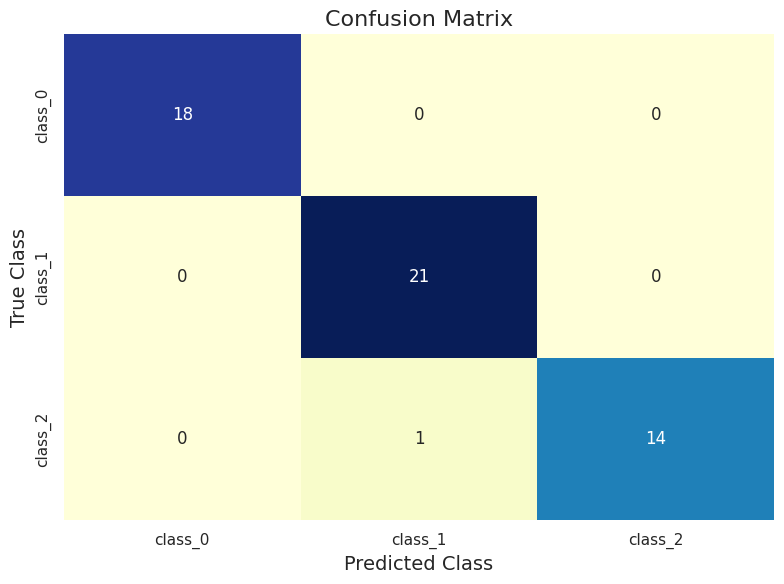

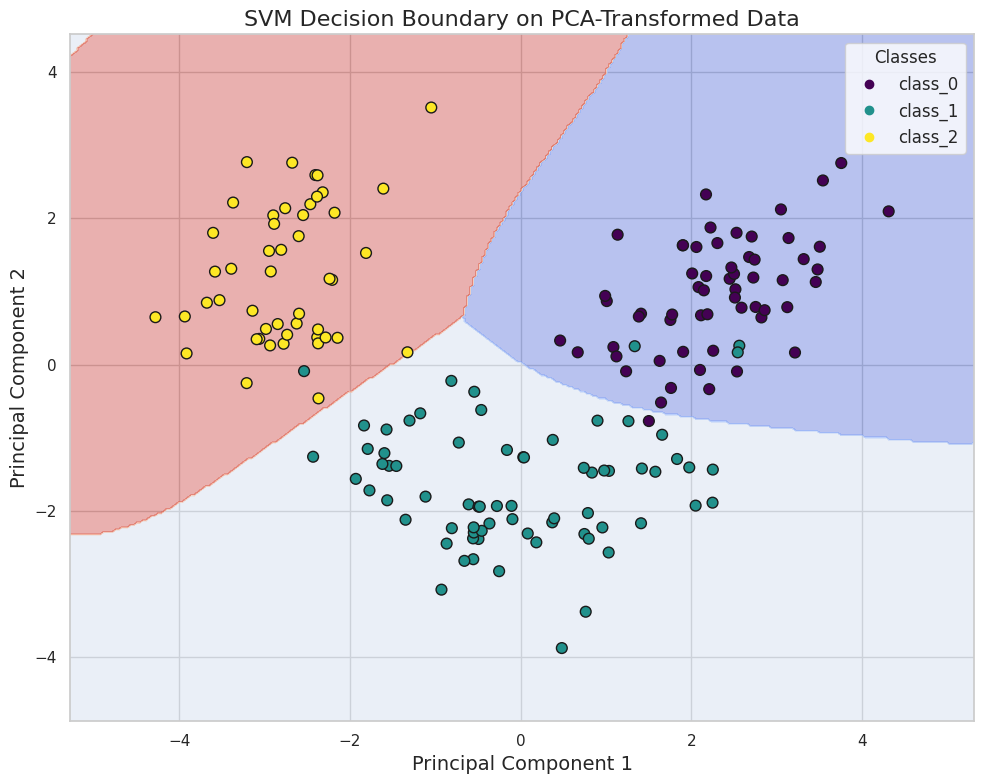

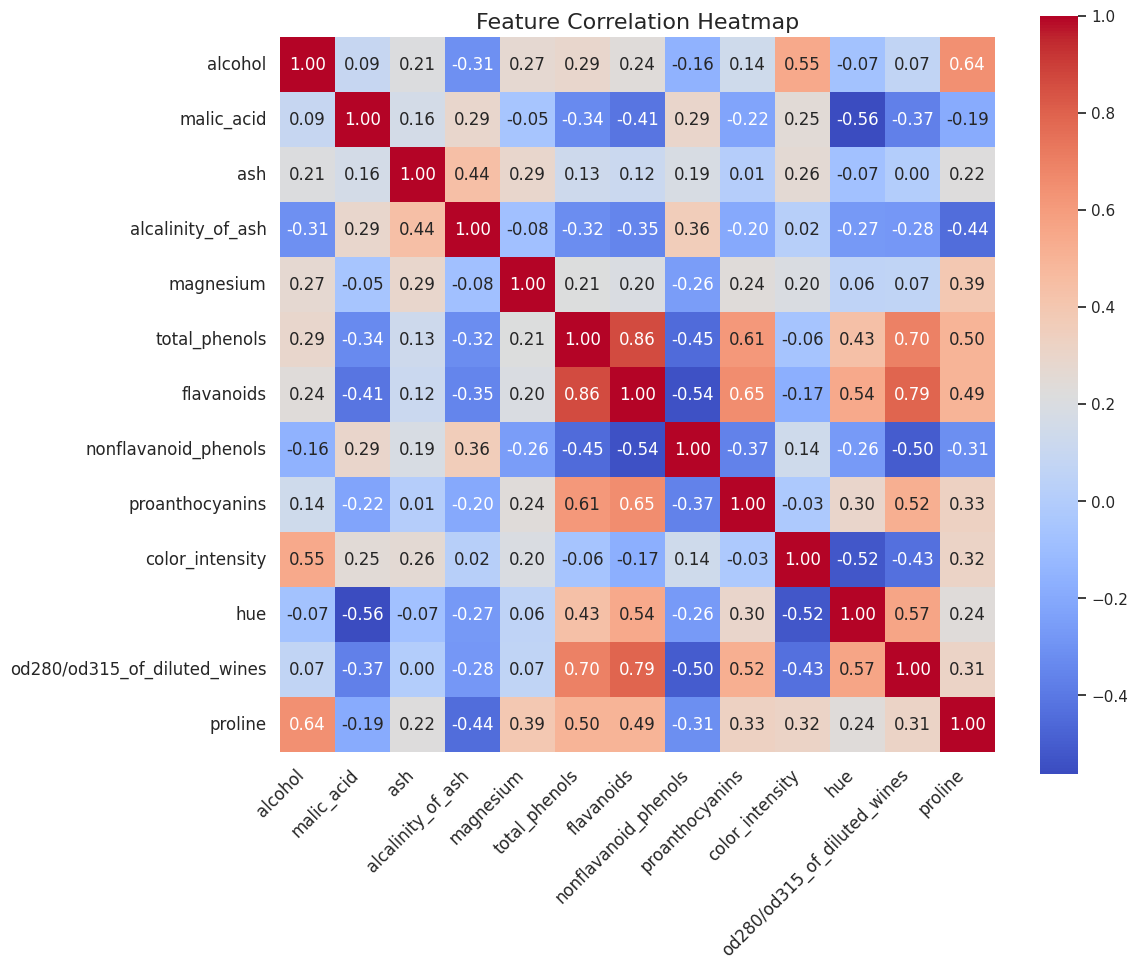

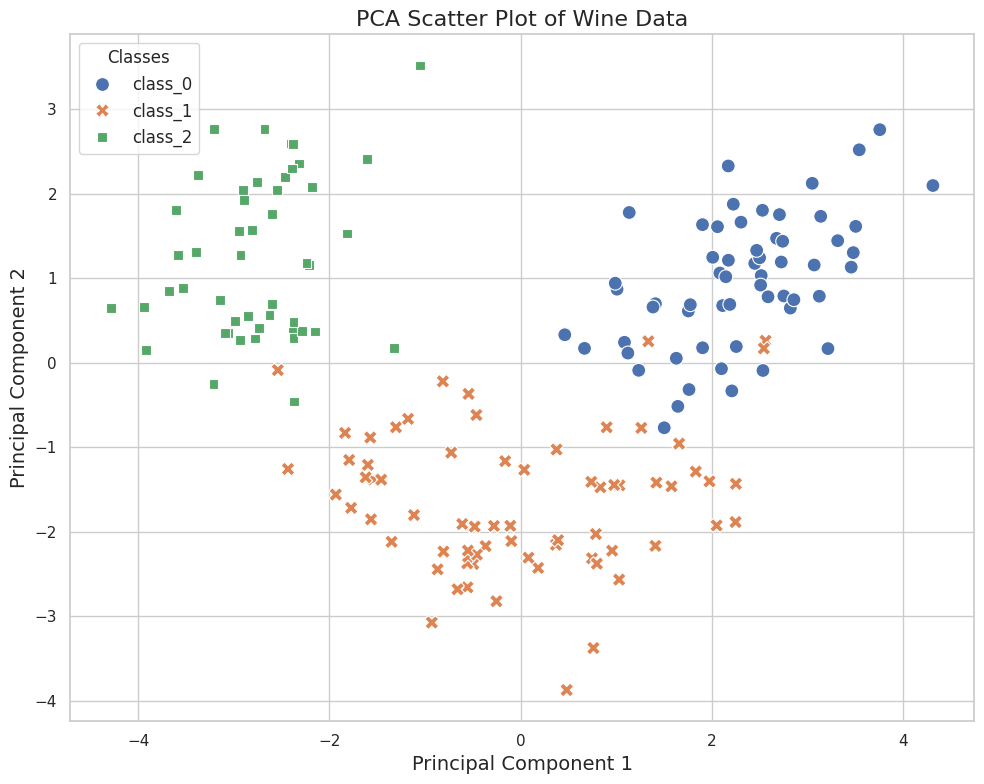

In [16]:
def main():
    # Load and preprocess data.
    X_scaled, y, df, feature_names, target_names = load_and_preprocess_data()

    # Split the dataset into training and testing subsets.
    X_train, X_test, y_train, y_test = split_data(X_scaled, y)

    # Train an SVM classifier on the standardized data.
    svm_model = train_svm_classifier(X_train, y_train)

    # Evaluate the model on the test set.
    y_pred, cm = evaluate_model(svm_model, X_test, y_test, target_names)

    # Plot the confusion matrix.
    plot_confusion_matrix(cm, target_names)

    # Plot the SVM decision boundary on PCA-transformed data.
    plot_pca_decision_boundary(svm_model, X_scaled, y, target_names)

    # Plot a heatmap of feature correlations.
    plot_feature_correlation_heatmap(df)

    # Plot a PCA scatter plot to visualize class separability.
    plot_pca_scatter(X_scaled, y, target_names)

if __name__ == "__main__":
    main()